# Importando Bibliotecas

In [1]:
#Vincular drive no google colab
#drive.mount('/content/drive/')

In [2]:
#Instalacao de Todos os pacotes necessários para execução do código
#pip install chart_studio numpy pandas matplotlib joblib keras tensorflow scikit-learn plotly seaborn statsmodels scipy

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(42)
seed(42)

droprate = 0.3

# Pré-processamento dos dados

* Carregando os dados
* Dividindo em treino, teste e validação
* Padronizando os dados


### Carregando Dados e convertendo para Array do Numpy. Configurado apenas para séries univariadas

In [4]:
dataframe = pd.read_csv('dataframe.csv')

In [5]:
dataframe.head(5)

index  hourly_demand
0  2022-04-26 01:00:00      65738.635
1  2022-04-26 02:00:00      63941.485
2  2022-04-26 03:00:00      62740.118
3  2022-04-26 04:00:00      62905.592
4  2022-04-26 05:00:00      64536.909

In [6]:
# Converter a coluna "Data" para datetime e definir como índice
dataframe['index'] = pd.to_datetime(dataframe['index'], errors='coerce')  # Tratar valores inválidos
dataframe = dataframe.dropna(subset=['index'])  # Remover valores inválidos
dataframe.set_index('index', inplace=True)

# Visualizar o dataframe após a transformação
print(dataframe.head())

                     hourly_demand
index                             
2022-04-26 01:00:00      65738.635
2022-04-26 02:00:00      63941.485
2022-04-26 03:00:00      62740.118
2022-04-26 04:00:00      62905.592
2022-04-26 05:00:00      64536.909


In [7]:
data = dataframe.values  # Converte o DataFrame para um array NumPy

### Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_prop = 0.7
valid_prop = 0.15
test_prop = 0.15

In [9]:
# Tamanho Total de Cada Conjunto
total_data_len = len(dataframe)
train_data_len = int(np.floor(total_data_len * train_prop))
valid_data_len = int(np.floor(total_data_len * valid_prop))
test_data_len = int(np.floor(total_data_len * test_prop))
print(total_data_len)
print(train_data_len)
print(valid_data_len)
print(test_data_len)


6000
4200
900
900


### Criando Treino, Validacao e Teste sem Padronizacao dos dados

In [10]:
# # Criando conjuntos de treinamento
# train_data = data[0:train_data_len, :]
# X_train, Y_train = [], []
# for i in range(60, len(train_data)):
#     X_train.append(train_data[i-60:i, 0])
#     Y_train.append(train_data[i, 0])

# X_train, Y_train = np.array(X_train), np.array(Y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# print(len(X_train))
# print(len(Y_train))
# print(len(train_data))

In [11]:
# # Criando o conjunto de validação
# valid_data = data[train_data_len:train_data_len + valid_data_len, :]
# X_valid, Y_valid = [], []

# for i in range(60, len(valid_data)):
#     X_valid.append(valid_data[i-60:i, 0])
#     Y_valid.append(valid_data[i, 0])

# X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
# X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
# Y_valid = np.array(Y_valid)

# print(len(X_valid))
# print(len(Y_valid))
# print(len(valid_data))

In [12]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
# Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

# X_test = []
# for i in range(60, len(test_data)):
#     X_test.append(test_data[i-60:i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
# print(len(Y_test))
# print(len(test_data))

### Treino, Teste e Validacao com padronizacao dos dados

In [13]:
# Criando o escalador
scaler = MinMaxScaler(feature_range=(0,1))


# Salvar o scaler para uso posterior
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [14]:
# Definir o número de passos de entrada e saída
n_steps_in, n_steps_out = 168, 1

In [15]:
# Transformar de Series Temporais para Amostras e Saída
def create_supervised_data(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in, 0])  # Todas as colunas, exceto a última
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, 0])  # Apenas a última coluna
    return np.array(X), np.array(Y)

### Divisão e Padronização dos Dados

In [16]:
# Definir proporção de treino
train_size = int(len(data) * train_prop)

# Dividir o conjunto de treino
train_data = data[:train_size]

# Padronizar o conjunto de treino
train_scaled = scaler.fit_transform(train_data)

X_train, Y_train = create_supervised_data(train_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de treino
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (4032, 168)
Y_train shape: (4032, 1)


In [17]:
# Definir proporção de validação
valid_size = int(len(data) * valid_prop)

# Dividir o conjunto de validação
valid_data = data[train_size:train_size + valid_size]

# Padronizar o conjunto de validação (usando parâmetros do treino)
valid_scaled = scaler.transform(valid_data)

# Criar dados supervisionados para validação
X_valid, Y_valid = create_supervised_data(valid_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de validação
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


X_valid shape: (732, 168)
Y_valid shape: (732, 1)


In [18]:
# O restante dos dados será usado para teste
test_data = data[train_size + valid_size:]

# Padronizar o conjunto de teste (usando parâmetros do treino)
test_scaled = scaler.transform(test_data)

# Criar dados supervisionados para teste
X_test, Y_test = create_supervised_data(test_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de teste
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_test shape: (732, 168)
Y_test shape: (732, 1)


### Conferindo Dimensão das Partições

In [19]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'Y_valid length: {len(Y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 4032
Y_train length: 4032
X_valid length: 732
Y_valid length: 732
X_test length: 732
Y_test length: 732


### Ajuste dos dados para os modelos LSTM e CNN

In [20]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (4032, 168, 1)
Validation set shape (732, 168, 1)
Test set shape (732, 168, 1)


# Funções de Métricas Utilizadas e Plot dos Resultados

In [21]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)

    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mae, mse, rmse, mape

In [22]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta

    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]

        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")

        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")

        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")

        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

In [23]:
def plot_multiple_loss(history_standard, history_reg, history_drop, history_reg_drop):

    # Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(history_standard.history['loss'], label='Treinamento')
    plt.plot(history_standard.history['val_loss'], label='Validação')
    plt.title('Modelo Simples: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(history_reg.history['loss'], label='Treinamento')
    plt.plot(history_reg.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(history_drop.history['loss'], label='Treinamento')
    plt.plot(history_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(history_reg_drop.history['loss'], label='Treinamento')
    plt.plot(history_reg_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
def plot_predicts(y_pred, y_pred_reg, y_pred_drop, y_pred_reg_drop):

    # Gráficos de predição
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred, label='Predito (Simples)', color='red')
    plt.title('Modelo Simples')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg, label='Predito (Reg)', color='red')
    plt.title('Modelo com Regularização')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_drop, label='Predito (Drop)', color='red')
    plt.title('Modelo com Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg_drop, label='Predito (Reg + Drop)', color='red')
    plt.title('Modelo com Regularização e Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [25]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001
neu_mlp1 = 256 #Quantidade de Neurônios Utilizados na Primeira Camada
neu_mlp2 = 64 #Quantidade de Neurônios Utilizados na Segunda Camada

### Analisando a Quantidade de Neuronios

In [26]:
# Função de criação do modelo MLP com 2 camadas ocultas
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model = Sequential()
    model.add(Dense(neurons_layer_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(neurons_layer_2, activation='relu'))  # Segunda camada
    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options_mlp = [16, 32, 64, 128, 256]
neurons_layer_2_options_mlp = [16, 32, 64, 128, 256]

# Armazenar resultados
results_mlp = []

Treinando modelo com 16 neurônios na primeira camada e 16 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 16 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 16 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira ca

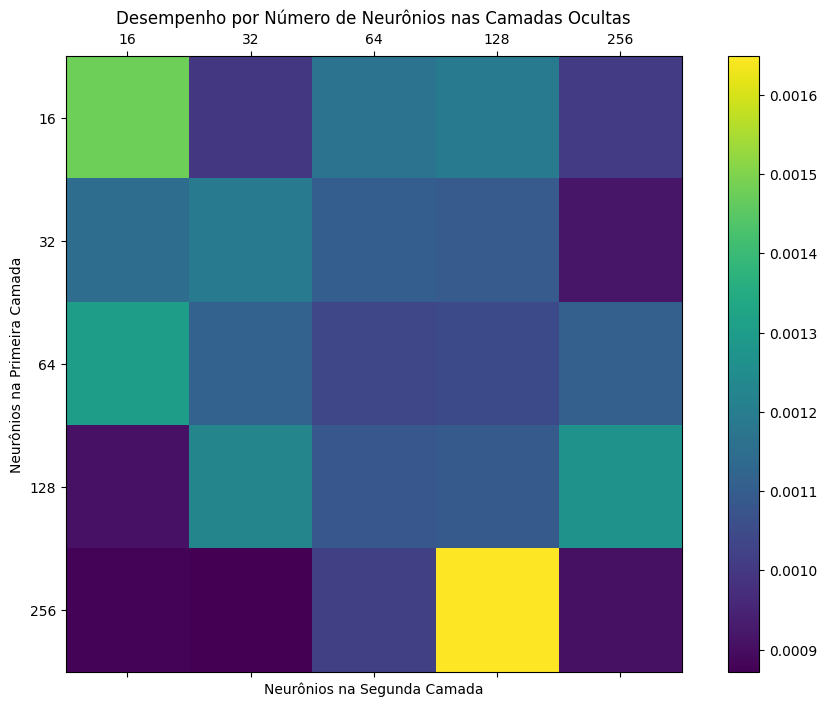

In [27]:
# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options_mlp:
    for neurons_layer_2 in neurons_layer_2_options_mlp:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=epochs_mlp, batch_size=batch_mlp, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results_mlp.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_df_mlp = pd.DataFrame(results_mlp)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table_mlp = results_df_mlp.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table_mlp, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options_mlp)))
ax.set_yticks(np.arange(len(neurons_layer_1_options_mlp)))
ax.set_xticklabels(neurons_layer_2_options_mlp)
ax.set_yticklabels(neurons_layer_1_options_mlp)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()

### Implementacao e ajuste do Modelo MLP

In [28]:
model_mlp = Sequential()
model_mlp.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(neu_mlp2))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [29]:
history_mlp = model_mlp.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_mlp,
                            batch_size=batch_mlp,
                            verbose=0)

### Implementacao e Ajuste do Modelo MLP com regularização

In [30]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1],
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(neu_mlp2, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [31]:
history_mlp_reg = model_mlp_reg.fit(X_train,
                                    Y_train,
                                    validation_data=(X_valid, Y_valid),
                                    epochs=epochs_mlp,
                                    batch_size=batch_mlp,
                                    verbose=1)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3481 - val_loss: 0.8196
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6335 - val_loss: 0.2873
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2274 - val_loss: 0.1176
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0934 - val_loss: 0.0568
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - val_loss: 0.0334
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254 - val_loss: 0.0232
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - val_loss: 0.0187
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - val_loss: 0.0160
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0141
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0129
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0121
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

### Implementacao e ajuste do modelo MLP com Dropout

In [32]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(droprate))
model_mlp_drop.add(Dense(neu_mlp2, activation='relu'))
model_mlp_drop.add(Dropout(droprate))
model_mlp_drop.add(Dense(1))
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [33]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train,
                                        Y_train,
                                        validation_data=(X_valid, Y_valid),
                                        epochs=epochs_mlp,
                                        batch_size=batch_mlp,
                                        verbose=1)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0628 - val_loss: 0.0334
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0136
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0222
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0126
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0110
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0117
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0106
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0128
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0123
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [34]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(neu_mlp1, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(droprate)) 
model_mlp_reg_drop.add(Dense(neu_mlp2, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(droprate))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [35]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train,
                                              Y_train,
                                              validation_data=(X_valid, Y_valid),
                                              epochs=epochs_mlp,
                                              batch_size=batch_mlp,
                                              verbose=1)


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3696 - mae: 0.2256 - val_loss: 0.2039 - val_mae: 0.1025
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1916 - mae: 0.0990 - val_loss: 0.1515 - val_mae: 0.0763
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1445 - mae: 0.0836 - val_loss: 0.1228 - val_mae: 0.1073
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1102 - mae: 0.0780 - val_loss: 0.0881 - val_mae: 0.0724
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0836 - mae: 0.0726 - val_loss: 0.0709 - val_mae: 0.0902
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0626 - mae: 0.0636 - val_loss: 0.0560 - val_mae: 0.0922
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0484 - mae: 0.0638 - val_loss: 0.0419 - val_mae: 0.0777
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0365 - mae: 0.0577 - val_loss: 0.0334 - val_mae: 0.0779
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

## Comparando os 4 modelos

In [36]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Modelo Padrão:
MAE: 0.0258
MSE: 0.0014
RMSE: 0.0368
MAPE: 6.8608%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Modelo com Regularização:
MAE: 0.0463
MSE: 0.0038
RMSE: 0.0615
MAPE: 24.6982%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Modelo com Dropout:
MAE: 0.0690
MSE: 0.0077
RMSE: 0.0878
MAPE: 33.2179%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Modelo com Regularização e Dropout:
MAE: 0.0573
MSE: 0.0056
RMSE: 0.0748
MAPE: 31.3308%


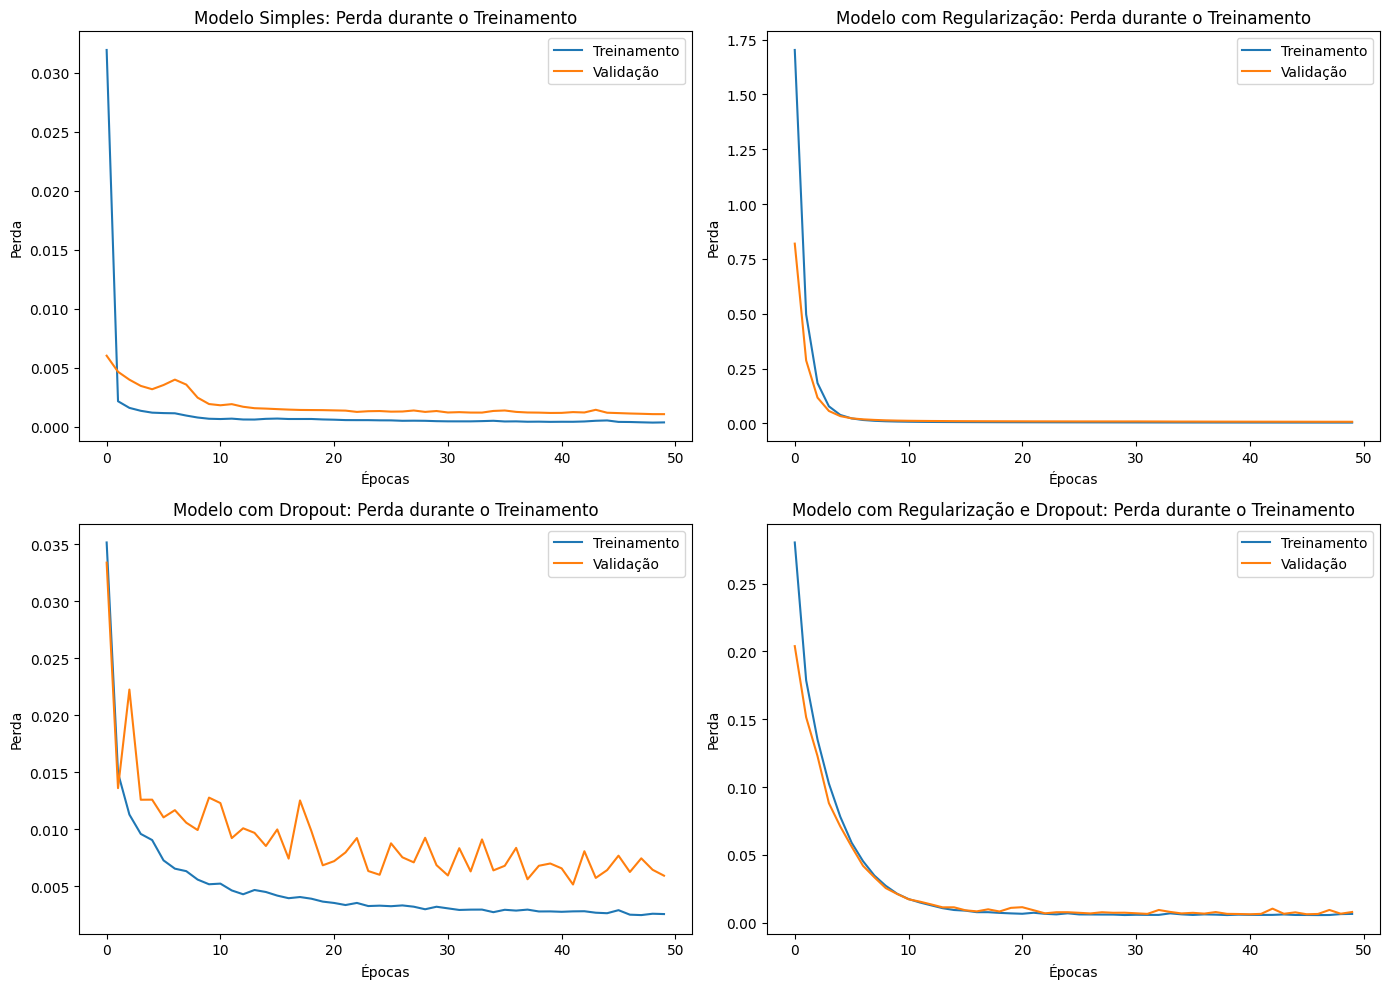

In [37]:
#Plot do Grafico de Perda
plot_multiple_loss(history_mlp, history_mlp_reg, history_mlp_drop, history_mlp_reg_drop)

In [38]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


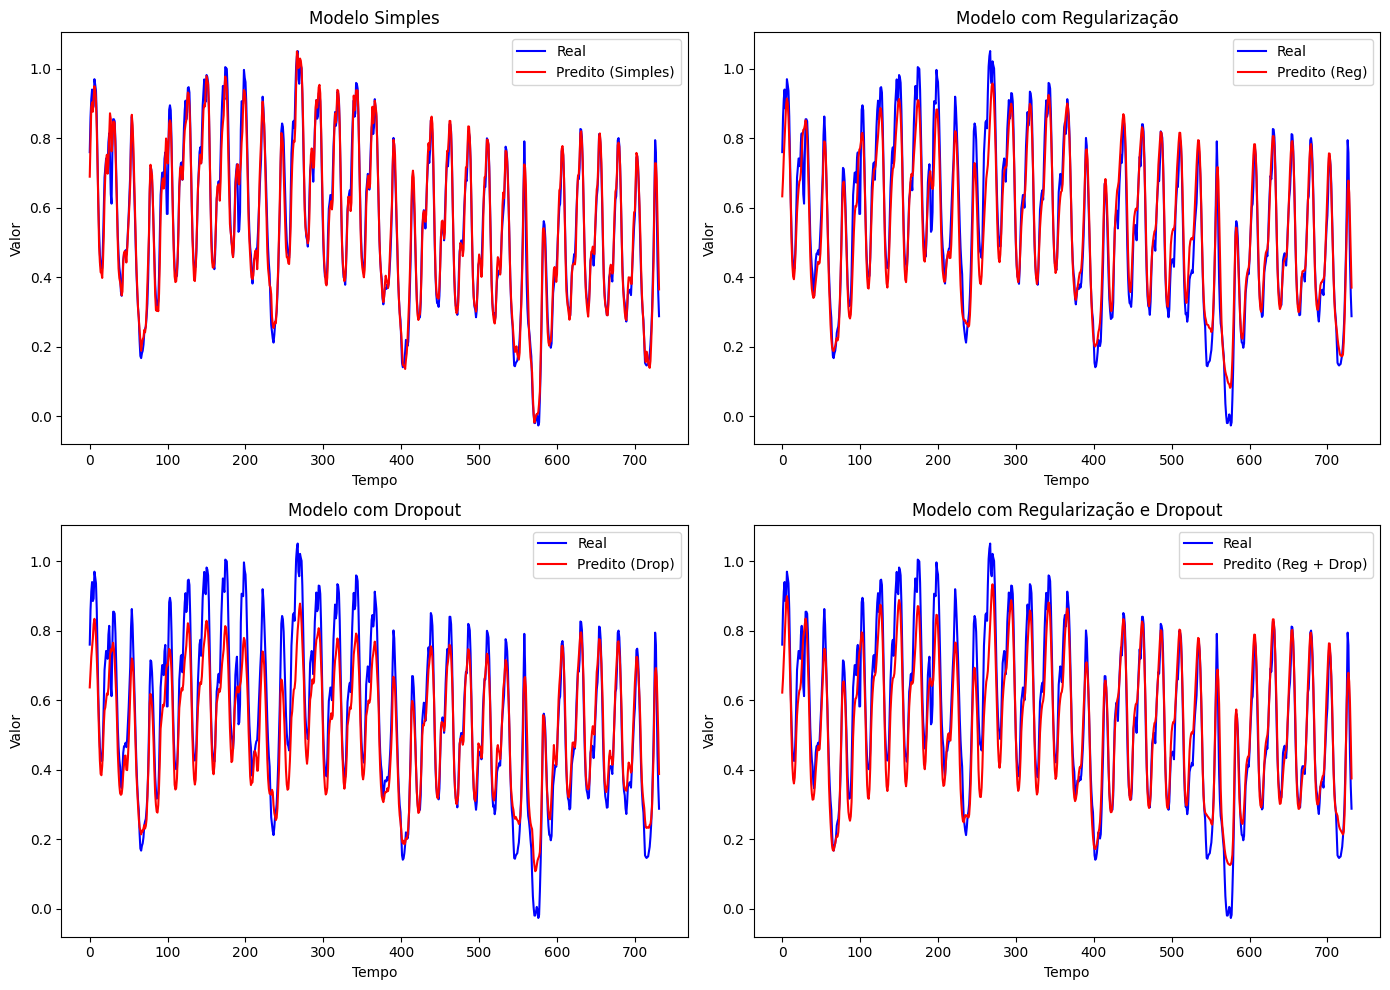

In [39]:
plot_predicts(y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop)

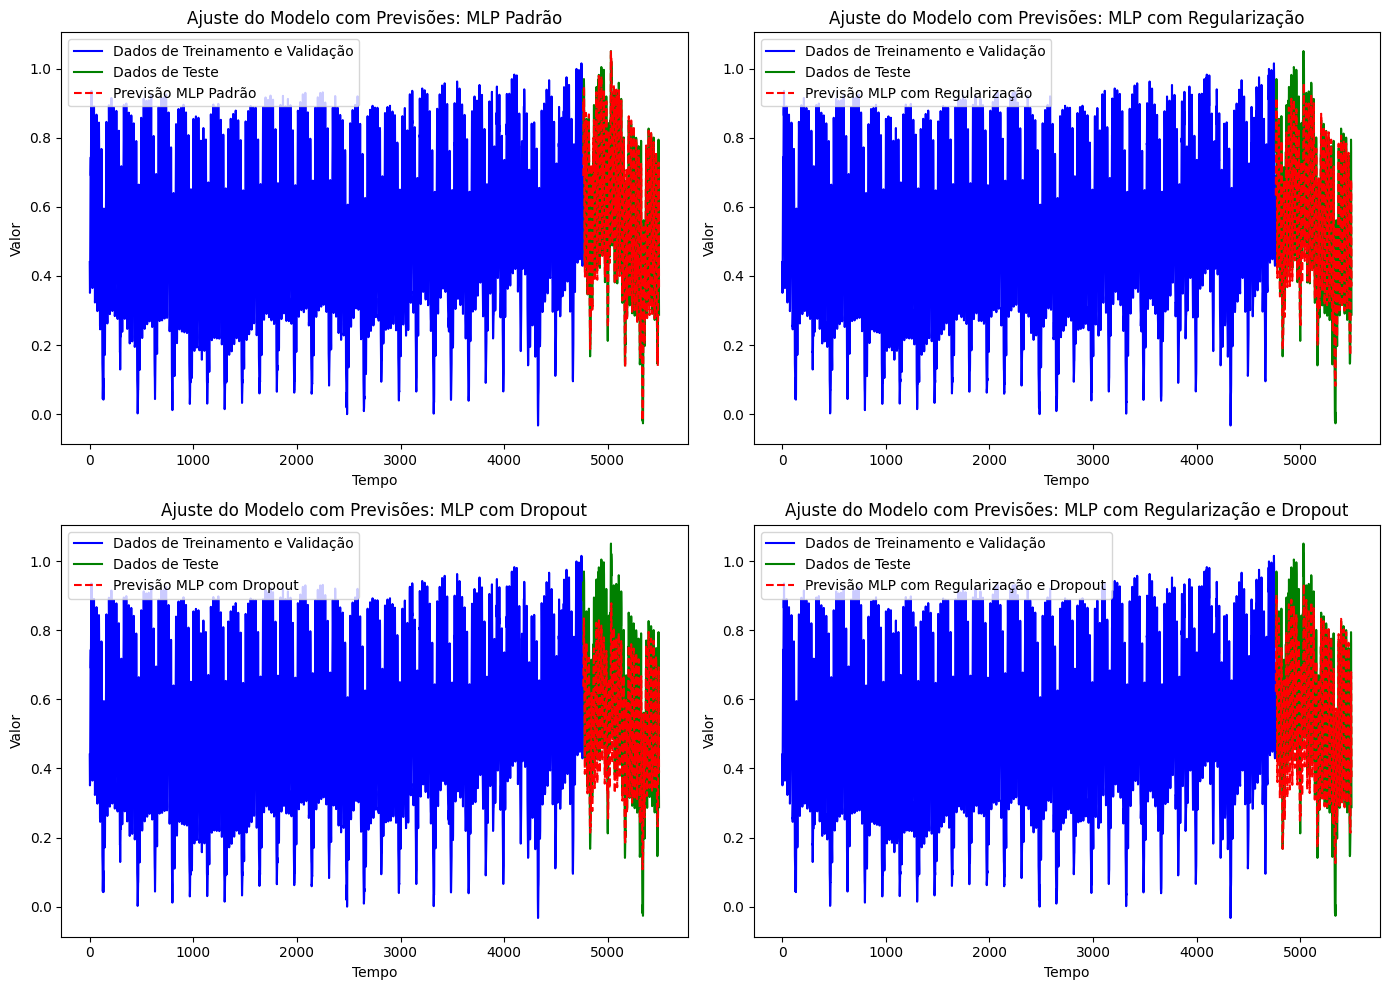

In [40]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [41]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
neu_cnn1 = 32 # Quantidade De Neuronios da Primeira camada
neu_cnn2 = 32 #Quantidade de Neuronios da Segunda Camada

### Analisando a Quantidade de Neuronios

In [42]:
# Função de criação do modelo MLP com 2 camadas ocultas
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=neurons_layer_1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(neurons_layer_2, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
    return model

# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options_cnn = [32, 64, 128, 256]
neurons_layer_2_options_cnn = [32, 64, 128, 256]

# Armazenar resultados
results_cnn = []

Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 256 neurônios na prim

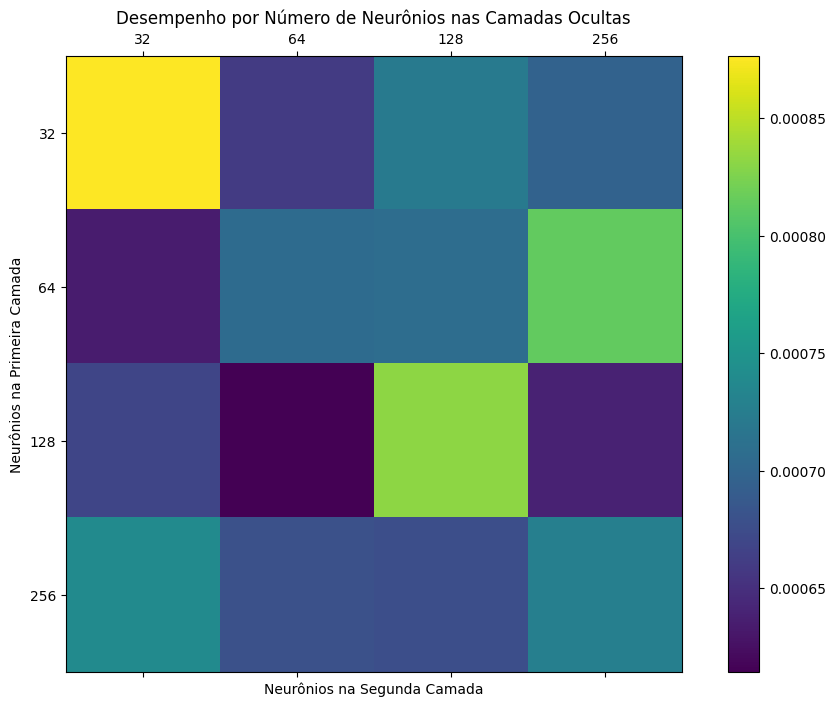

In [43]:

# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options_cnn:
    for neurons_layer_2 in neurons_layer_2_options_cnn:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=35, batch_size=32, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results_cnn.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})


results_df_cnn = pd.DataFrame(results_cnn)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table = results_df_cnn.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options_cnn)))
ax.set_yticks(np.arange(len(neurons_layer_1_options_cnn)))
ax.set_xticklabels(neurons_layer_2_options_cnn)
ax.set_yticklabels(neurons_layer_1_options_cnn)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()


## Implementando e Ajustando Modelo CNN

In [44]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(neu_cnn2, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [45]:
history_cnn = model_cnn.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_cnn,
                            batch_size=batch_cnn,
                            verbose=1)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0469 - val_loss: 0.0110
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0077
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7577e-04 - val_loss: 0.0031
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8046e-04 - val_loss: 0.0028
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8694e-04 - val_loss: 0.0026
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━

## Implementando e Ajustando Modelo CNN com Regularização L2

In [46]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(neu_cnn2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [47]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3289 - val_loss: 0.0527
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0360 - val_loss: 0.0255
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0196
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0191
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - val_loss: 0.0182
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0173
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0161
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0156
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0150
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0149
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0146
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

## Implementando e Ajustando Modelo CNN com Dropout

In [48]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(droprate))
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(neu_cnn2, activation='relu'))
model_cnn_drop.add(Dropout(droprate))
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_drop.summary()

In [49]:
history_cnn_drop = model_cnn_drop.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0624 - val_loss: 0.0149
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0209 - val_loss: 0.0116
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - val_loss: 0.0078
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [50]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(droprate))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(neu_cnn2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(droprate))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg_drop.summary()

In [51]:
history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series,
                                            Y_train,
                                            validation_data=(X_valid_series, Y_valid),
                                            epochs=epochs_cnn,
                                            batch_size=batch_cnn,
                                            verbose=1)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3676 - val_loss: 0.0628
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0543 - val_loss: 0.0318
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0311 - val_loss: 0.0310
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0259
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.0230
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - val_loss: 0.0213
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188 - val_loss: 0.0272
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0185 - val_loss: 0.0242
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0217
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0220
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0191
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

## Comparando os 4 Modelos CNN

In [52]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [53]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo Padrão:
MAE: 0.0334
MSE: 0.0022
RMSE: 0.0470
MAPE: 14.6923%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização:
MAE: 0.0630
MSE: 0.0070
RMSE: 0.0835
MAPE: 34.4808%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Dropout:
MAE: 0.0598
MSE: 0.0059
RMSE: 0.0766
MAPE: 35.4595%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0777
MSE: 0.0109
RMSE: 0.1043
MAPE: 62.3044%


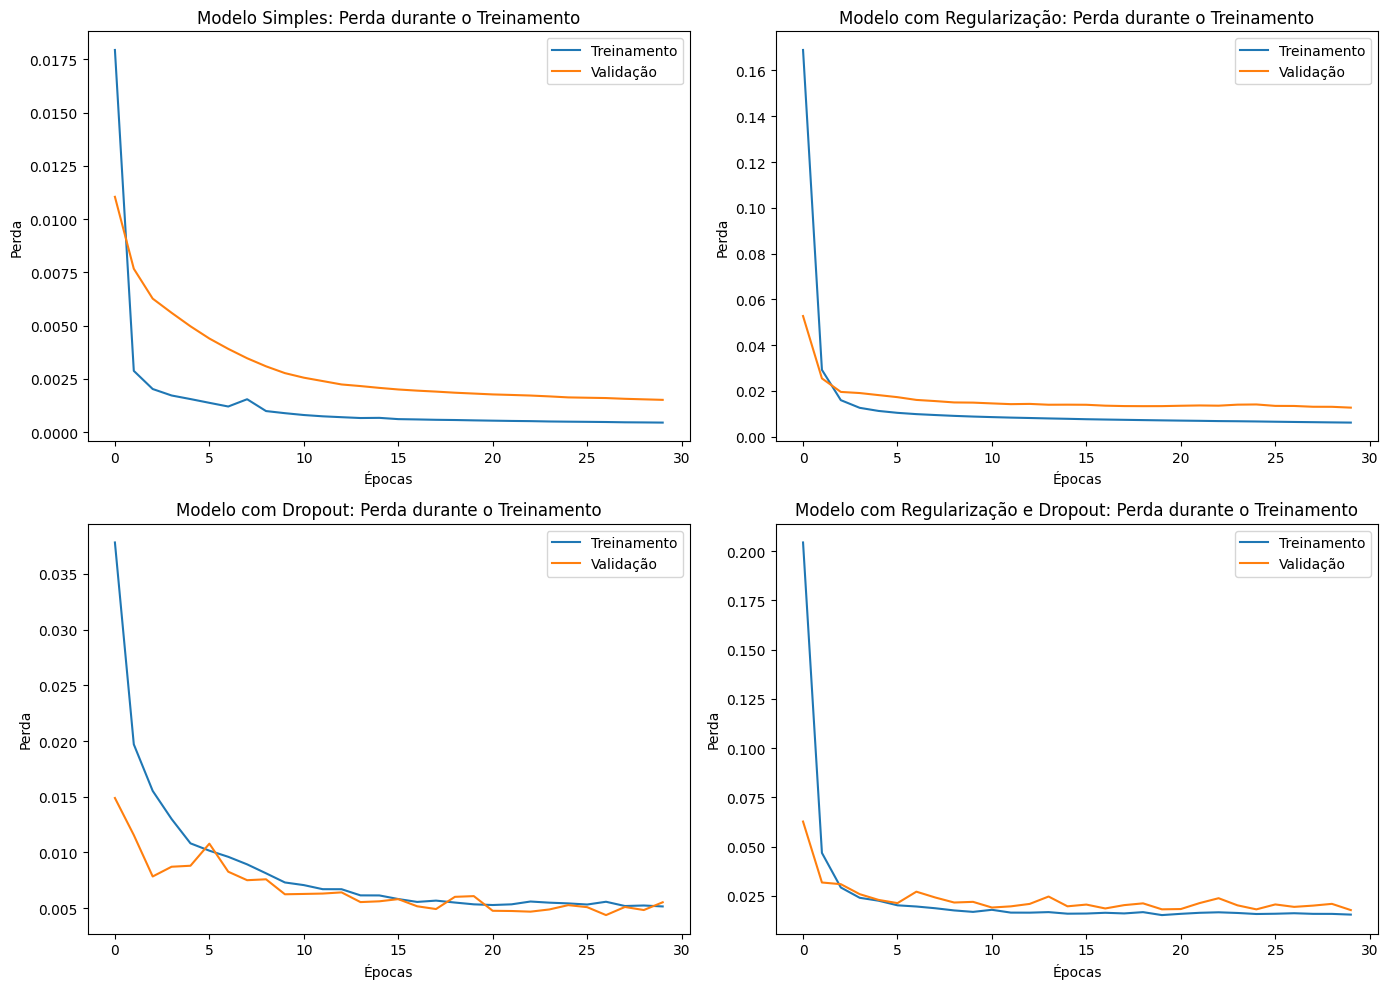

In [54]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn, history_cnn_reg, history_cnn_drop, history_cnn_reg_drop)

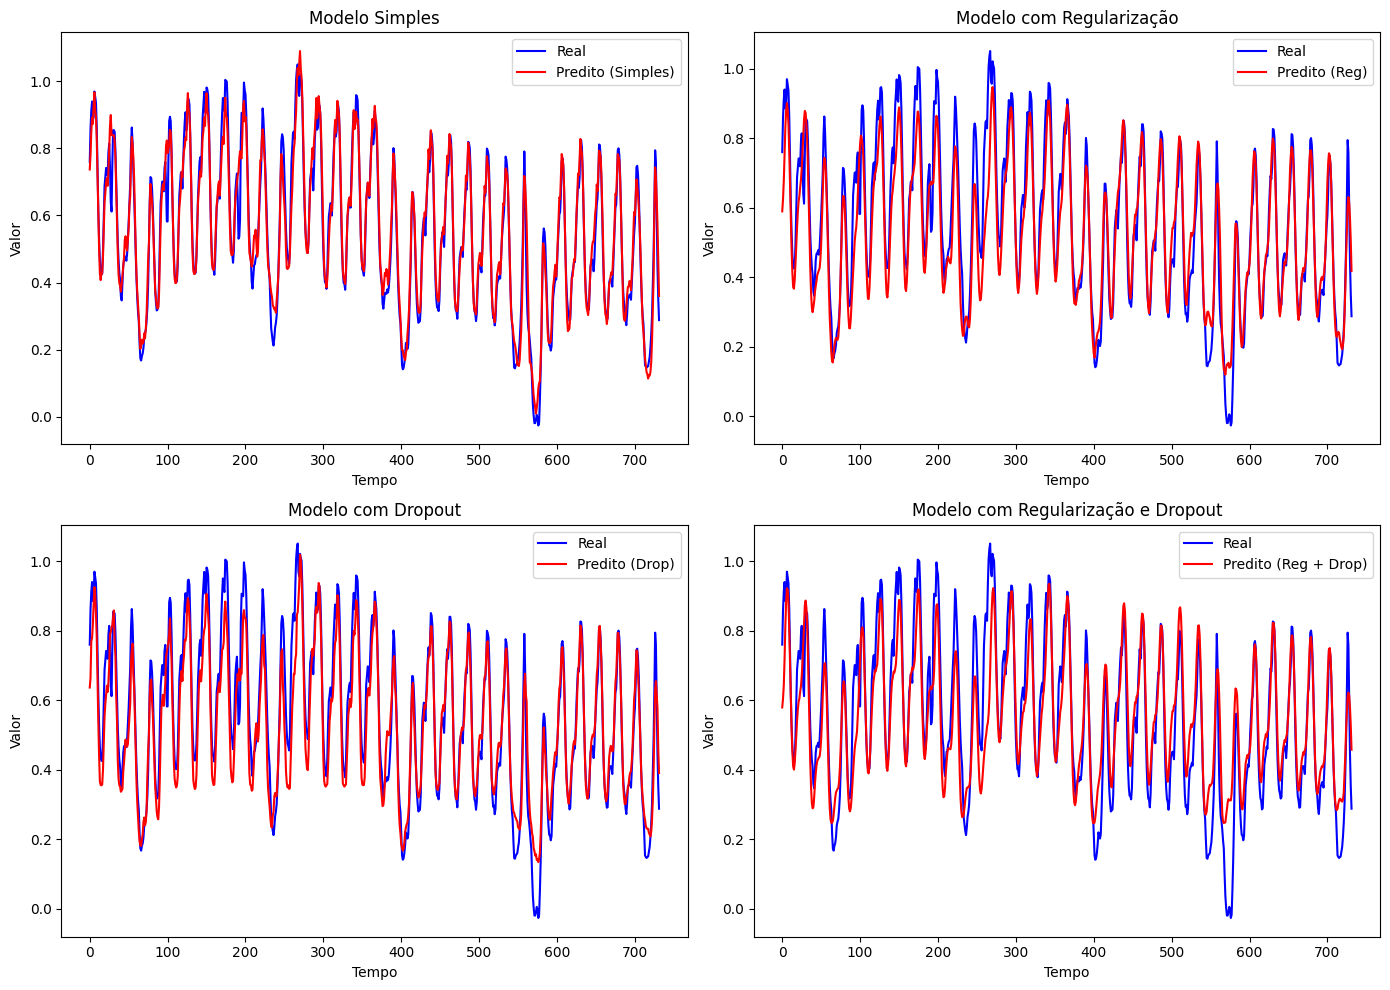

In [55]:
plot_predicts(y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop)

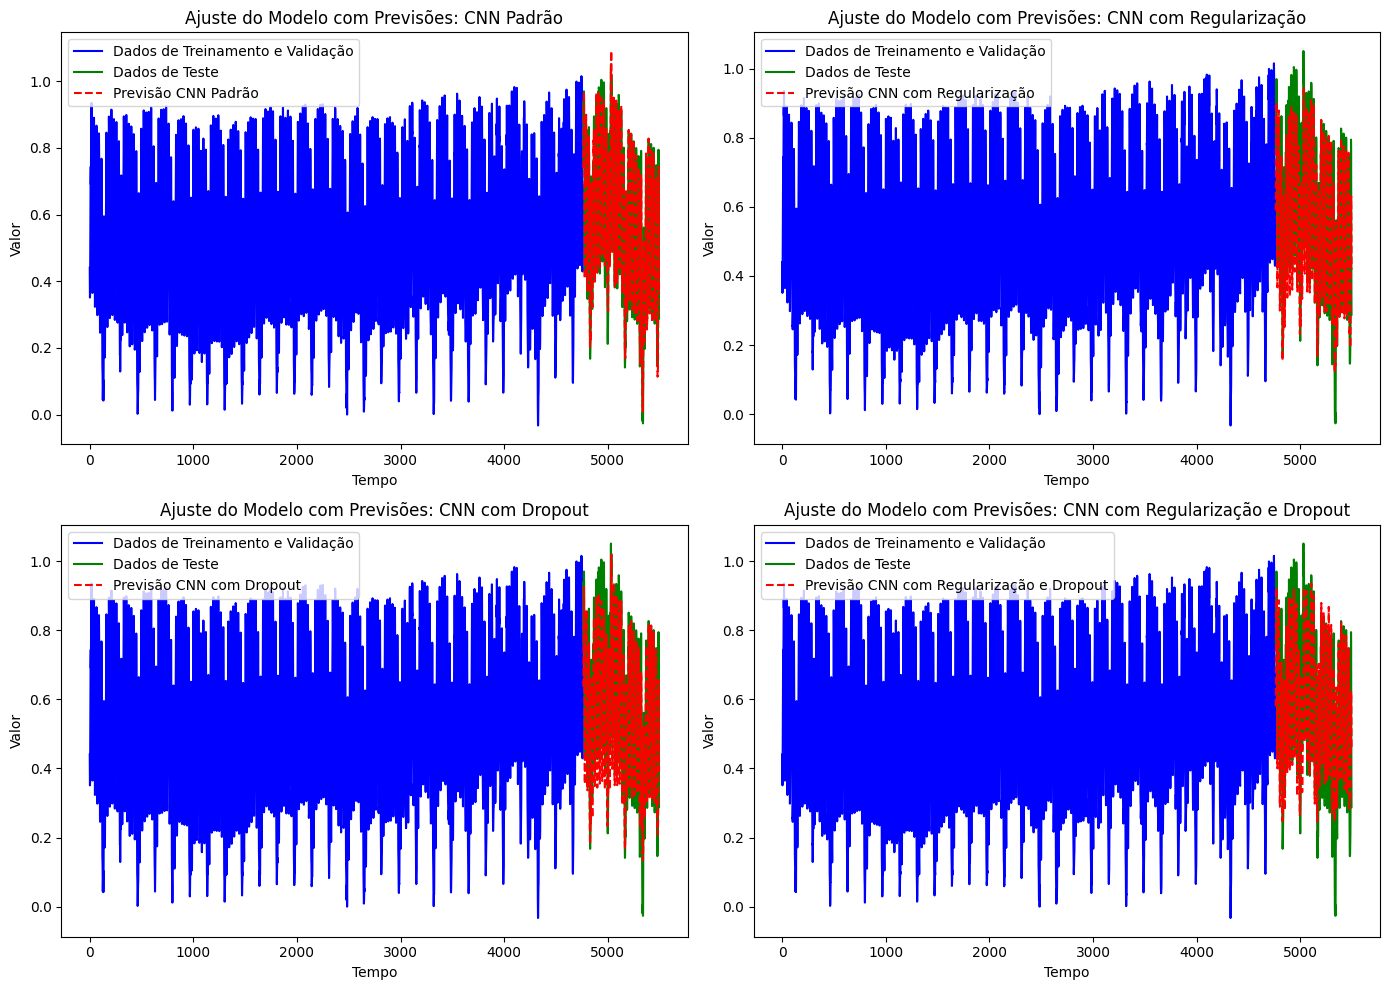

In [56]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [57]:
#Hiperparametros
epochs_lstm = 30
batch_lstm = 32
lr_lstm = 0.001
neu_lstm1 = 32 #Quantidade de Neuronios da Primeira Camada
neu_lstm2 = 32 #Quantidade de Neuronios da Segunda Camada

### Analisando Quantidade de Neuronios

In [58]:
# Definir a função de criação do modelo MLP (como exemplo)
def create_mlp_model(neurons):
    model_lstm_test = Sequential()
    model_lstm_test.add(LSTM(neurons, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    model_lstm_test.add(Dense(1))
    model_lstm_test.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
    return model

# Lista de diferentes quantidades de neurônios a testar
neurons_options = [16, 24, 32, 48, 64, 82, 128, 256, 512]

# Armazenar resultados
results_lstm = []

Treinando modelo com 16 neurônios...
Treinando modelo com 24 neurônios...
Treinando modelo com 32 neurônios...
Treinando modelo com 48 neurônios...
Treinando modelo com 64 neurônios...
Treinando modelo com 82 neurônios...
Treinando modelo com 128 neurônios...
Treinando modelo com 256 neurônios...
Treinando modelo com 512 neurônios...


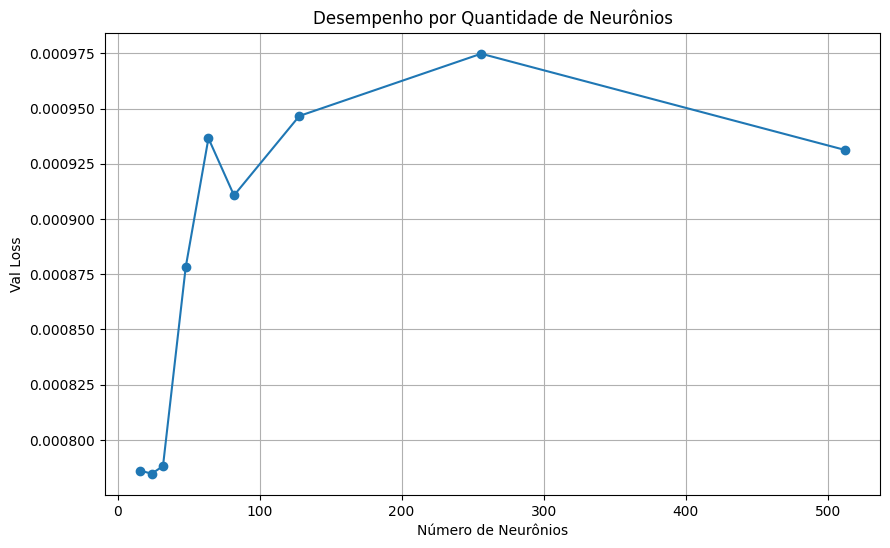

In [59]:
# Loop para testar diferentes quantidades de neurônios
for neurons in neurons_options:
    print(f"Treinando modelo com {neurons} neurônios...")
    
    # Criar o modelo
    model = create_mlp_model(neurons)
    
    # Treinar o modelo
    history = model.fit(X_train, Y_train, epochs=epochs_lstm, batch_size=batch_lstm, validation_data=(X_valid, Y_valid), verbose=0)
    
    # Obter o desempenho (pode ser MAPE, RMSE, etc.)
    val_loss = history.history['val_loss'][-1]
    
    # Armazenar o desempenho
    results_lstm.append({'neurons': neurons, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_lstm_df = pd.DataFrame(results_lstm)

# Gerar gráfico
plt.figure(figsize=(10,6))
plt.plot(results_lstm_df['neurons'], results_lstm_df['val_loss'], marker='o')
plt.title('Desempenho por Quantidade de Neurônios')
plt.xlabel('Número de Neurônios')
plt.ylabel('Val Loss')
plt.grid(True)
plt.show()

## Implementacao e Ajuste do Modelo LSTM

In [60]:
model_lstm = Sequential()
model_lstm.add(LSTM(neu_lstm1, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [61]:
history_lstm = model_lstm.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0263 - val_loss: 0.0212
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0218 - val_loss: 0.0184
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0191 - val_loss: 0.0156
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0162 - val_loss: 0.0127
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0129 - val_loss: 0.0099
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0098 - val_loss: 0.0077
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [62]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(neu_lstm1, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [63]:
history_lstm_reg = model_lstm_reg.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=0)


## Implementacao e Ajuste do Modelo LSTM com Dropout

In [64]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(neu_lstm1, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(droprate))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [65]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series,
                                              Y_train,
                                              epochs=epochs_lstm,
                                              batch_size=batch_lstm,
                                              validation_data=(X_valid, Y_valid),
                                              verbose=1)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.1222 - val_loss: 0.0251
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0369 - val_loss: 0.0182
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0267 - val_loss: 0.0121
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0209 - val_loss: 0.0101
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0183 - val_loss: 0.0076
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0159 - val_loss: 0.0069
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0157 - val_loss: 0.0072
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0140 - val_loss: 0.0063
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0126 - val_loss: 0.0059
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0120 - val_loss: 0.0055
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0115 - val_loss: 0.0051
Epoch 12/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [66]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        neu_lstm1,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(droprate))
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [67]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series,
                            Y_train,
                            epochs=epochs_lstm,
                            batch_size=batch_lstm,
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

Epoch 1/30
126/126 - 6s - 48ms/step - loss: 0.0684 - val_loss: 0.0329
Epoch 2/30
126/126 - 4s - 32ms/step - loss: 0.0342 - val_loss: 0.0228
Epoch 3/30
126/126 - 4s - 32ms/step - loss: 0.0266 - val_loss: 0.0162
Epoch 4/30
126/126 - 4s - 33ms/step - loss: 0.0228 - val_loss: 0.0151
Epoch 5/30
126/126 - 4s - 33ms/step - loss: 0.0206 - val_loss: 0.0123
Epoch 6/30
126/126 - 4s - 32ms/step - loss: 0.0189 - val_loss: 0.0098
Epoch 7/30
126/126 - 4s - 34ms/step - loss: 0.0169 - val_loss: 0.0103
Epoch 8/30
126/126 - 5s - 36ms/step - loss: 0.0156 - val_loss: 0.0091
Epoch 9/30
126/126 - 5s - 41ms/step - loss: 0.0147 - val_loss: 0.0085
Epoch 10/30
126/126 - 5s - 36ms/step - loss: 0.0134 - val_loss: 0.0086
Epoch 11/30
126/126 - 5s - 36ms/step - loss: 0.0124 - val_loss: 0.0086
Epoch 12/30
126/126 - 5s - 41ms/step - loss: 0.0121 - val_loss: 0.0098
Epoch 13/30
126/126 - 5s - 36ms/step - loss: 0.0118 - val_loss: 0.0082
Epoch 14/30
126/126 - 5s - 37ms/step - loss: 0.0119 - val_loss: 0.0086
Epoch 15/30
126

## Comparativo entre os modelos - Predicao e Validacao

In [68]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Modelo Padrão:
MAE: 0.0332
MSE: 0.0019
RMSE: 0.0435
MAPE: 12.4736%
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Modelo com Regularização:
MAE: 0.0510
MSE: 0.0045
RMSE: 0.0671
MAPE: 23.4399%
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Modelo com Dropout:
MAE: 0.0475
MSE: 0.0050
RMSE: 0.0704
MAPE: 21.3248%
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Modelo com Regularização e Dropout:
MAE: 0.0598
MSE: 0.0058
RMSE: 0.0762
MAPE: 40.0288%


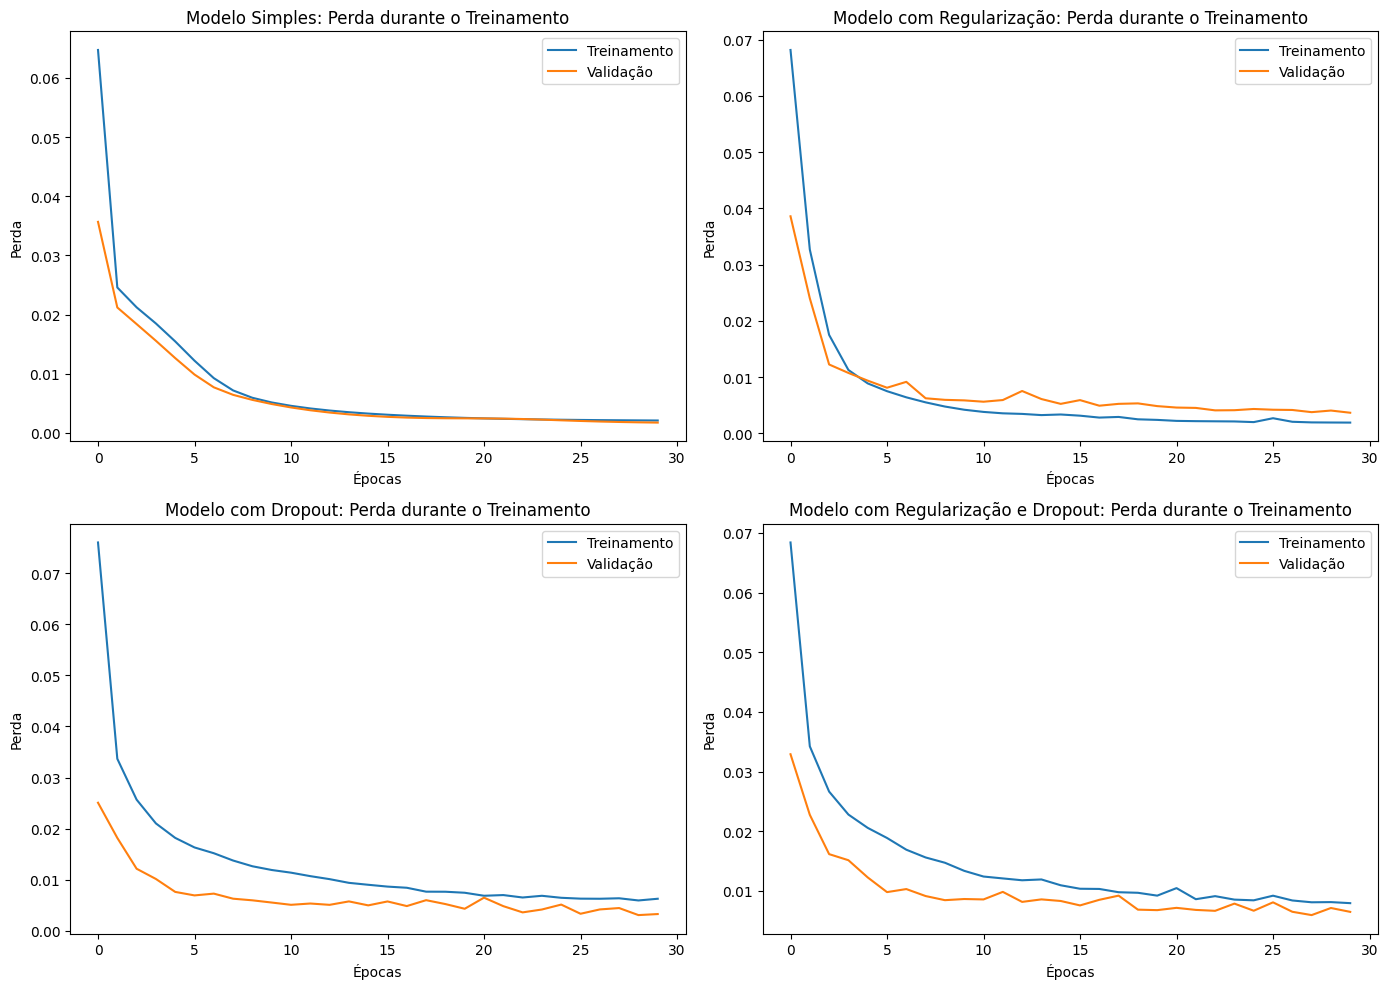

In [69]:
#Plot do Grafico de Perda
plot_multiple_loss(history_lstm, history_lstm_reg, history_lstm_drop, history_lstm_reg_drop)

In [70]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


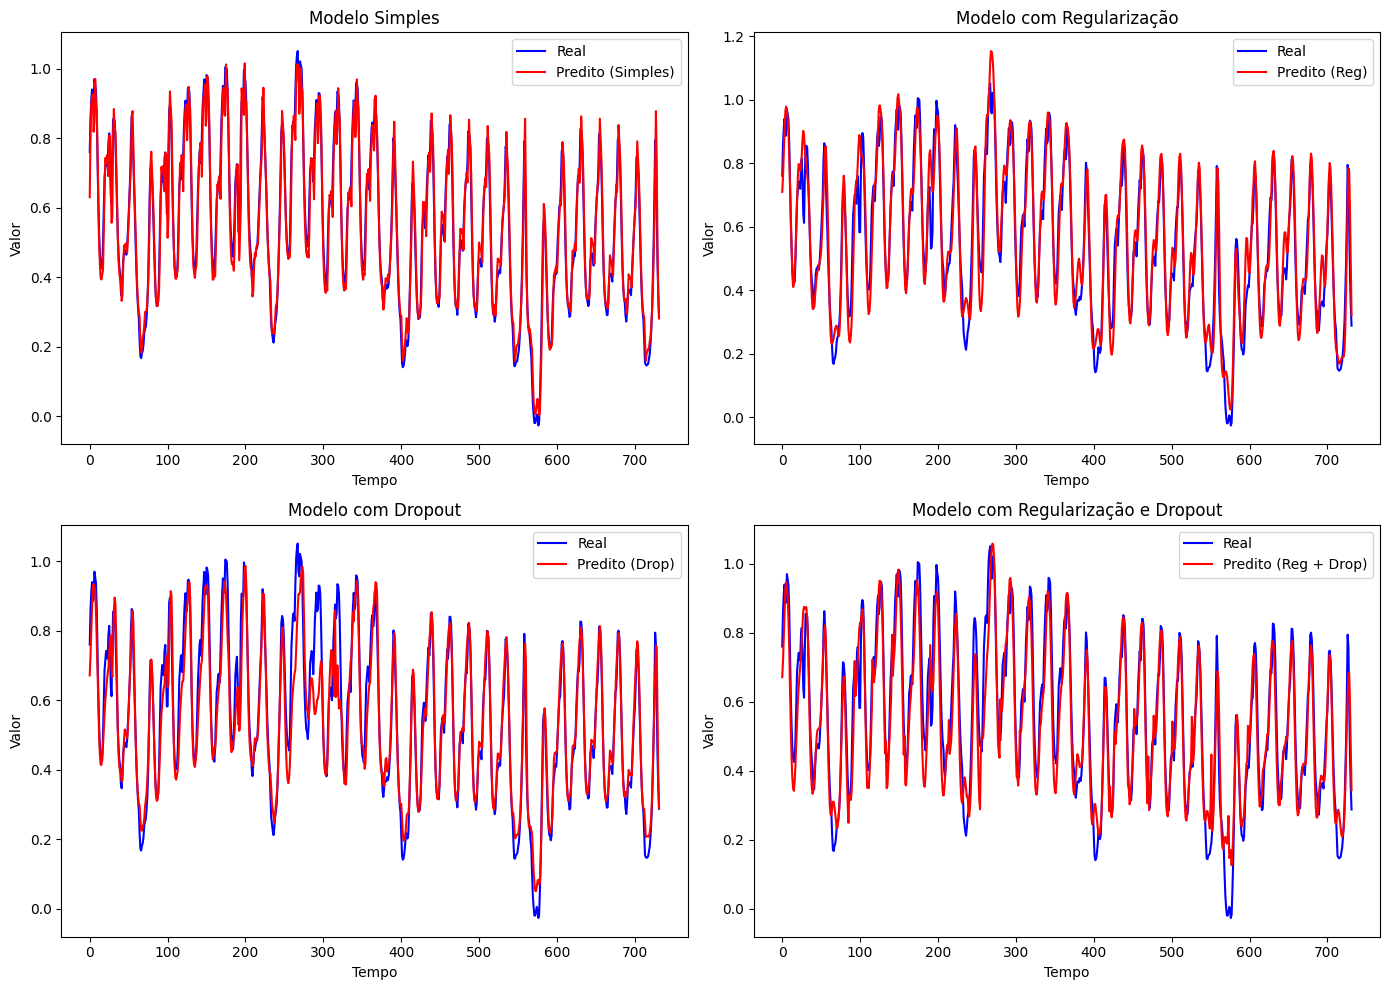

In [71]:
plot_predicts(y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop)

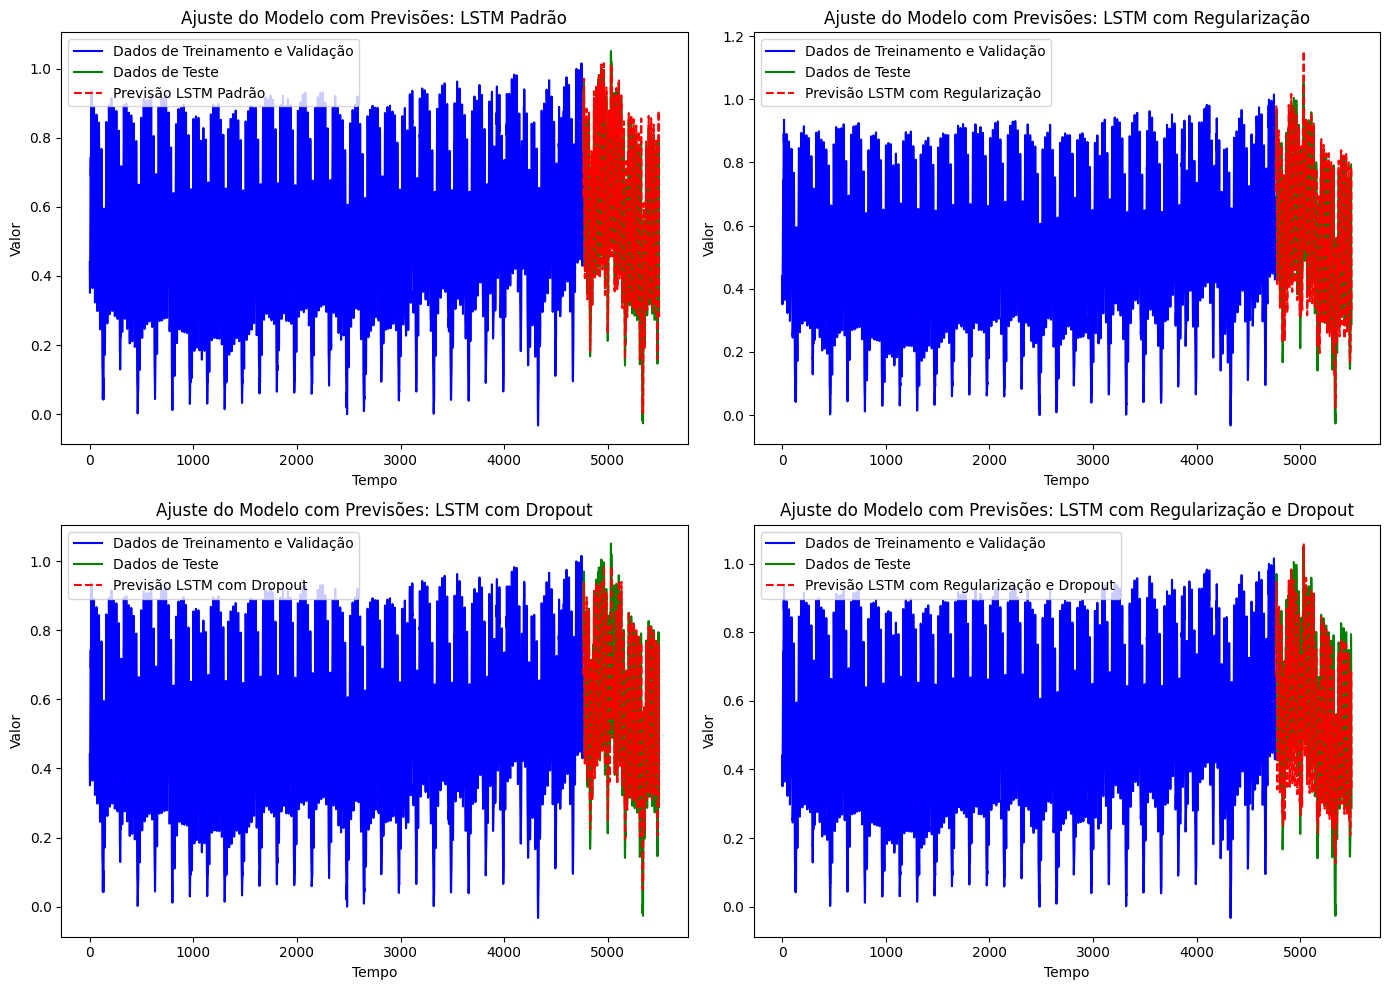

In [72]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [73]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2
neu_cnn = 256 #Quantidade de Neuronios na Camada de CNN
neu_lstm = 64 #Quantidade de Neuronios na Camada de LSTM

In [74]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (4032, 2, 84, 1)
Validation set shape (732, 2, 84, 1)
Test set shape (732, 2, 84, 1)


### Analisando a Quantidade de Neuronios

In [75]:
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(filters=neurons_layer_1, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neurons_layer_2, activation='relu'))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))
    return model


# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options_cnn_lstm = [32, 64, 128, 256]
neurons_layer_2_options_cnn_lstm = [32, 64, 128, 256]

# Armazenar resultados
results_cnn_lstm = []

Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 256 neurônios na prim

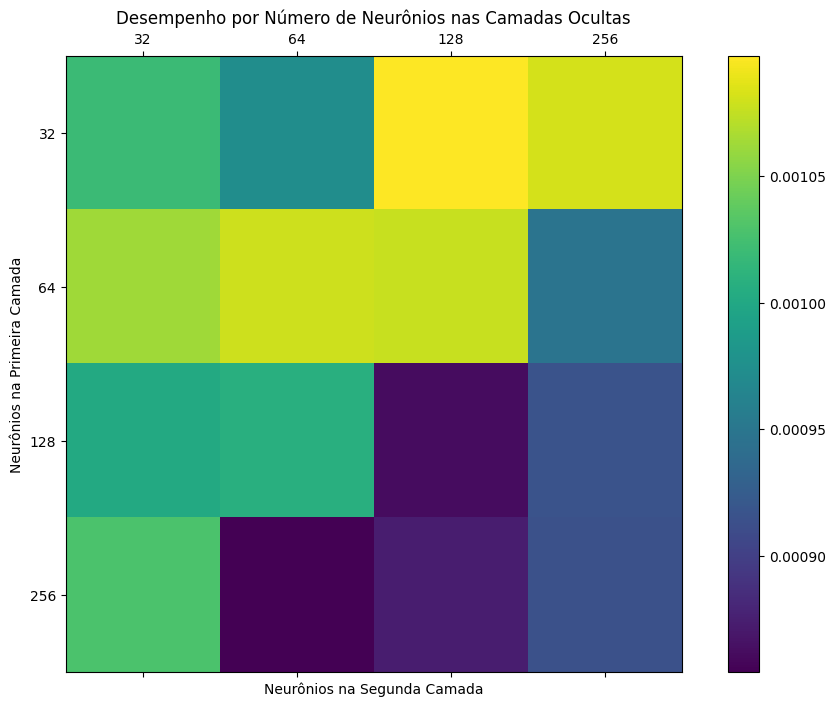

In [76]:
# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options_cnn_lstm:
    for neurons_layer_2 in neurons_layer_2_options_cnn_lstm:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=epochs_hibrid, batch_size=batch_hibrid, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results_cnn_lstm.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})


results_df = pd.DataFrame(results_cnn_lstm)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table = results_df.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options_cnn_lstm)))
ax.set_yticks(np.arange(len(neurons_layer_1_options_cnn_lstm)))
ax.set_xticklabels(neurons_layer_2_options_cnn_lstm)
ax.set_yticklabels(neurons_layer_1_options_cnn_lstm)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()

## Implementacao e ajuste do modelo padrao

In [77]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(neu_lstm, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [78]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub,
                                      Y_train,
                                      validation_data=(X_valid_series_sub, Y_valid),
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid,
                                      verbose=1)

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0302 - val_loss: 0.0049
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 9.9859e-04 - val_loss: 0.0018
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 9.4586e-04 - val_loss: 0.0017
Epoch 12/30
126/126 ━━━━━━━━━━━━

## Implementacao e Ajuste do modelo com Regularizacao

In [79]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(neu_lstm, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [80]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub,
                                              Y_train,
                                              validation_data=(X_valid_series_sub, Y_valid),
                                              epochs=epochs_hibrid,
                                              batch_size = batch_hibrid,
                                              verbose=1)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.1885 - val_loss: 0.0304
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.0195 - val_loss: 0.0150
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.0075 - val_loss: 0.0110
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 0.0072 - val_loss: 0.0099
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0067 - val_loss: 0.0093
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0062 - val_loss: 0.0104
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0066 - val_loss: 0.0097
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.0061 - val_loss: 0.0092
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0068 - val_loss: 0.0094
Epoch 12/30
126/126

## Implementacao e Ajuste do Modelo com Dropout

In [81]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(droprate))
model_cnn_lstm_drop.add(LSTM(neu_lstm, activation='relu'))
model_cnn_lstm_drop.add(Dropout(droprate))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [82]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub,
                                                Y_train,
                                                validation_data=(X_valid_series_sub, Y_valid),
                                                epochs=epochs_hibrid,
                                                batch_size = batch_hibrid,
                                                verbose=1)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - loss: 0.0746 - val_loss: 0.0107
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.0132 - val_loss: 0.0156
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.0093 - val_loss: 0.0047
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0065 - val_loss: 0.0112
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 12/30
126/126

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [83]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(droprate))
model_cnn_lstm_reg_drop.add(LSTM(neu_lstm, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(droprate))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub,
                                                        Y_train,
                                                        validation_data=(X_valid_series_sub, Y_valid),
                                                        epochs=epochs_hibrid,
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.2286 - val_loss: 0.0353
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - loss: 0.0352 - val_loss: 0.0222
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.0233 - val_loss: 0.0154
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0188 - val_loss: 0.0147
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0177 - val_loss: 0.0152
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.0173 - val_loss: 0.0137
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0150 - val_loss: 0.0134
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 9/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0136 - val_loss: 0.0122
Epoch 10/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.0137 - val_loss: 0.0121
Epoch 11/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 12/30
126/126

## Comparativo entre os modelos

In [84]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [85]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Modelo Padrão:
MAE: 0.0290
MSE: 0.0016
RMSE: 0.0405
MAPE: 13.6620%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Modelo com Regularização:
MAE: 0.0587
MSE: 0.0055
RMSE: 0.0738
MAPE: 33.3996%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Modelo com Dropout:
MAE: 0.0620
MSE: 0.0063
RMSE: 0.0792
MAPE: 41.5919%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Modelo com Regularização e Dropout:
MAE: 0.0630
MSE: 0.0067
RMSE: 0.0817
MAPE: 41.3718%


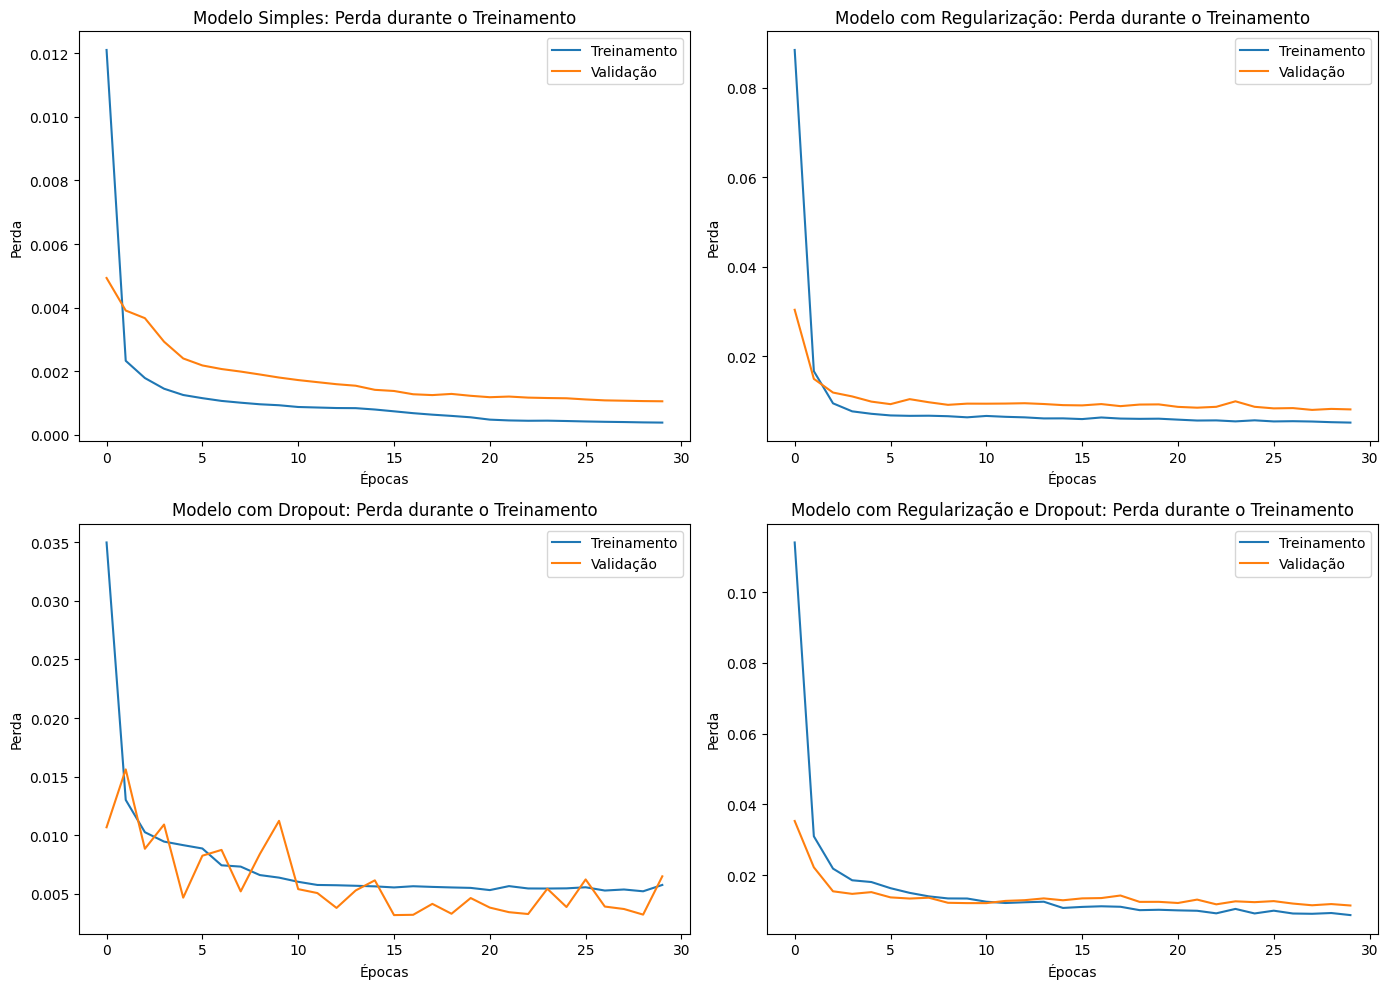

In [86]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn_lstm, history_cnn_lstm_reg, history_cnn_lstm_drop, history_cnn_lstm_reg_drop)

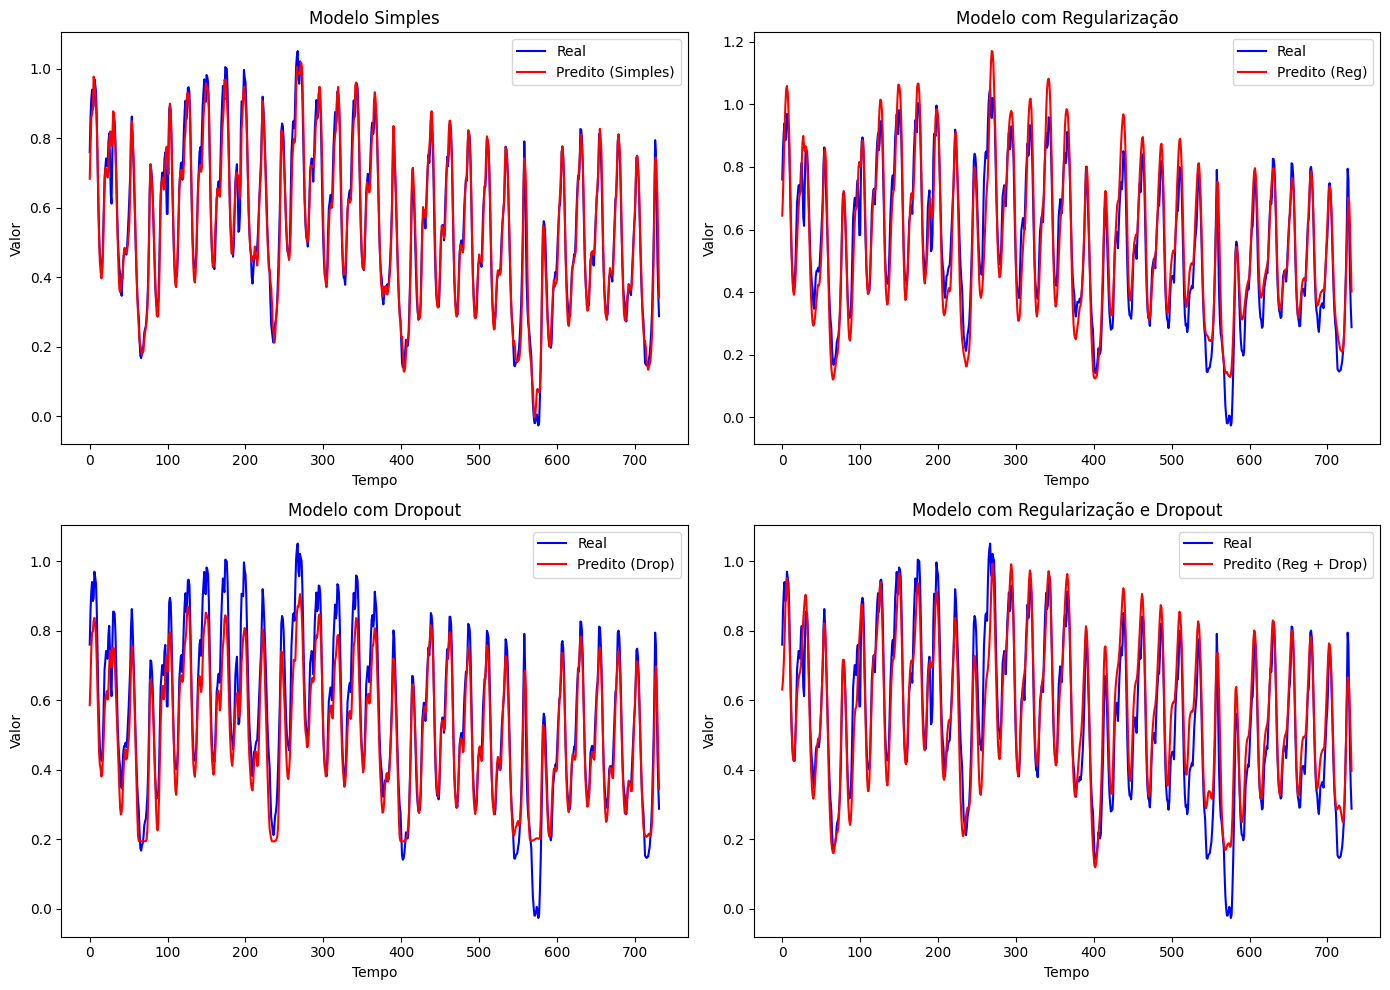

In [87]:
plot_predicts(y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop)

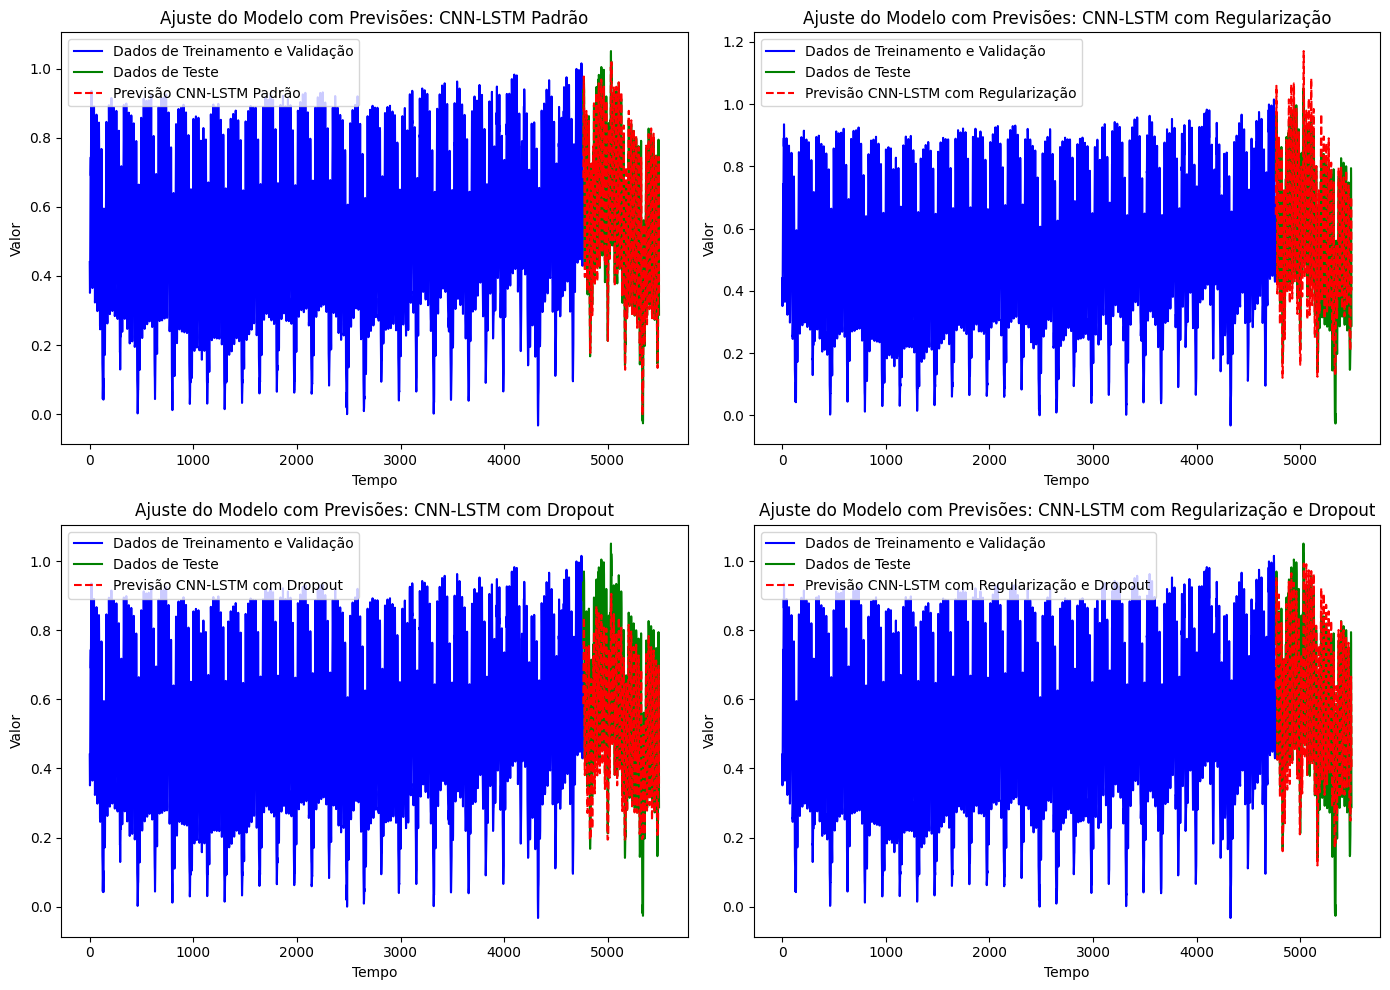

In [88]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# Testando Looping de Neuronios


Treinando modelo com 16 neurônios...
Treinando modelo com 24 neurônios...
Treinando modelo com 32 neurônios...
Treinando modelo com 48 neurônios...
Treinando modelo com 64 neurônios...
Treinando modelo com 82 neurônios...
Treinando modelo com 128 neurônios...
Treinando modelo com 256 neurônios...
Treinando modelo com 512 neurônios...


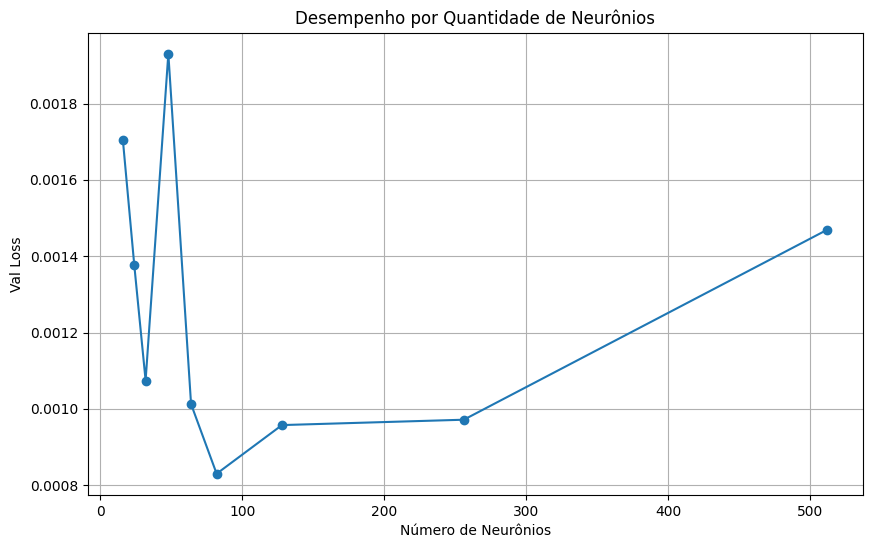

In [89]:
import matplotlib.pyplot as plt

# Definir a função de criação do modelo MLP (como exemplo)
def create_mlp_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Lista de diferentes quantidades de neurônios a testar
neurons_options = [16, 24, 32, 48, 64, 82, 128, 256, 512]

# Armazenar resultados
results = []

# Loop para testar diferentes quantidades de neurônios
for neurons in neurons_options:
    print(f"Treinando modelo com {neurons} neurônios...")
    
    # Criar o modelo
    model = create_mlp_model(neurons)
    
    # Treinar o modelo
    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=0)
    
    # Obter o desempenho (pode ser MAPE, RMSE, etc.)
    val_loss = history.history['val_loss'][-1]
    
    # Armazenar o desempenho
    results.append({'neurons': neurons, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_df = pd.DataFrame(results)

# Gerar gráfico
plt.figure(figsize=(10,6))
plt.plot(results_df['neurons'], results_df['val_loss'], marker='o')
plt.title('Desempenho por Quantidade de Neurônios')
plt.xlabel('Número de Neurônios')
plt.ylabel('Val Loss')
plt.grid(True)
plt.show()


Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 256 neurônios na prim

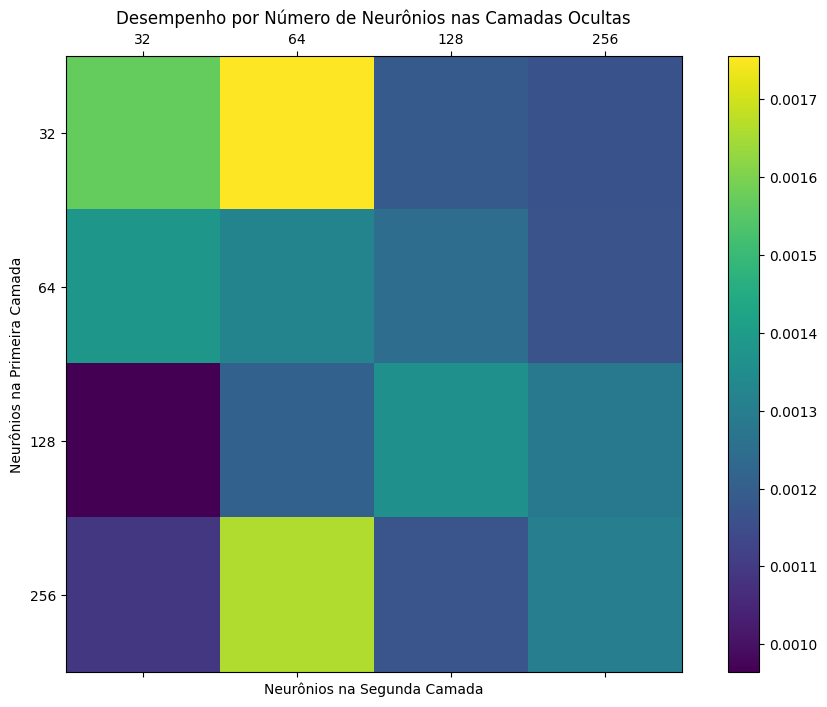

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Função de criação do modelo MLP com 2 camadas ocultas
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model = Sequential()
    model.add(Dense(neurons_layer_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(neurons_layer_2, activation='relu'))  # Segunda camada
    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options = [32, 64, 128, 256]
neurons_layer_2_options = [32, 64, 128, 256]

# Armazenar resultados
results = []

# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options:
    for neurons_layer_2 in neurons_layer_2_options:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=35, batch_size=32, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_df = pd.DataFrame(results)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table = results_df.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options)))
ax.set_yticks(np.arange(len(neurons_layer_1_options)))
ax.set_xticklabels(neurons_layer_2_options)
ax.set_yticklabels(neurons_layer_1_options)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()
